In [1]:
import torch

def binomial_coeffs(n, device=None):
    i = torch.arange(n + 1, device=device)
    return torch.exp(
        torch.lgamma(torch.tensor(n + 1.0, device=device)) -
        torch.lgamma(i + 1.0) -
        torch.lgamma(torch.tensor(n - i + 1.0, device=device))
    )  # (D,)

def bernstein_basis_batched(x, n, binom=None):
    """
    Compute Bernstein basis for batched x.

    Args:
        x: Tensor (B, N) with values in [0, 1]
        n: degree
        binom: (D,) optional precomputed binomial coefficients

    Returns:
        Tensor of shape (B, N, D)
    """
    B, N = x.shape
    D = n + 1
    device = x.device

    if binom is None:
        binom = binomial_coeffs(n, device=device)  # (D,)

    i = torch.arange(D, device=device).view(1, 1, D)  # (1, 1, D)
    x = x.unsqueeze(-1)  # (B, N, 1)

    basis = binom.view(1, 1, D) * x**i * (1 - x)**(n - i)  # (B, N, D)
    return basis

def bernstein_prediction_batched(x, theta):
    """
    Compute Bernstein predictions for batched inputs.

    Args:
        x: Tensor (B, N)
        theta: Tensor (B, D)

    Returns:
        f(x): Tensor (B, N)
    """
    B, D = theta.shape
    n = D - 1
    basis = bernstein_basis_batched(x, n)  # (B, N, D)
    return torch.matmul(basis, theta.unsqueeze(-1)).squeeze(-1)  # (B, N)


In [2]:
def bernstein_first_derivative_batched(x, theta):
    B, D = theta.shape
    n = D - 1
    dtheta = n * (theta[:, 1:] - theta[:, :-1])  # (B, D-1)
    basis = bernstein_basis_batched(x, n - 1, binomial_coeffs(n - 1, x.device))  # (B, N, D-1)
    return torch.matmul(basis, dtheta.unsqueeze(-1)).squeeze(-1)  # (B, N)

def bernstein_second_derivative_batched(x, theta):
    B, D = theta.shape
    n = D - 1
    ddtheta = n * (n - 1) * (
        theta[:, 2:] - 2 * theta[:, 1:-1] + theta[:, :-2]
    )  # (B, D-2)
    basis = bernstein_basis_batched(x, n - 2, binomial_coeffs(n - 2, x.device))  # (B, N, D-2)
    return torch.matmul(basis, ddtheta.unsqueeze(-1)).squeeze(-1)  # (B, N)


In [19]:
B, N, D = 1, 1000, 11  # 4 polynomials, 100 points each, degree 10
x = torch.linspace(0, 1, N).repeat(B, 1)  # (B, N)
theta = torch.rand(B, D)  # (B, D)
theta = torch.tensor([0,1,2,3,4,5,0,-1,0,1,1]).float().unsqueeze(0)  # Example coefficients for degree 10

f = bernstein_prediction_batched(x, theta)         # (B, N)
f_prime = bernstein_first_derivative_batched(x, theta)   # (B, N)
f_double_prime = bernstein_second_derivative_batched(x, theta)  # (B, N)


/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_52139/1472525969.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.lgamma(torch.tensor(n - i + 1.0, device=device))


In [20]:
import matplotlib.pyplot as plt

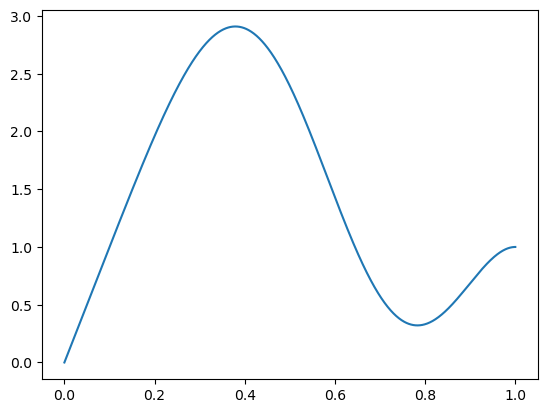

In [21]:
plt.plot(x[0,:],f[0,:])

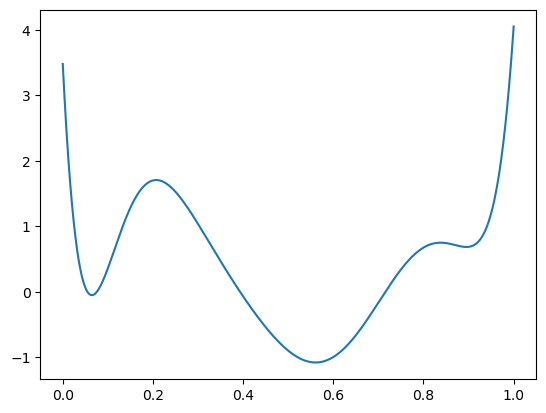

In [11]:
plt.plot(x[0,:],f_prime[0,:])

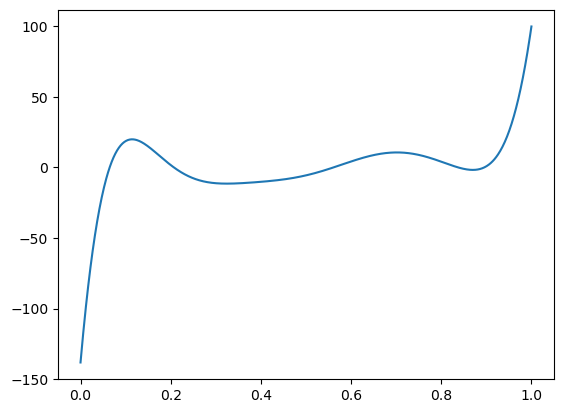

In [12]:
plt.plot(x[0,:],f_double_prime[0,:])